In [1]:
:extension OverloadedStrings
:load QNKAT/Definitions.hs
:load QNKAT/Drawing.hs

[Documentation](../view/dist-newstyle/build/x86_64-linux/ghc-9.0.2/qnkat-playground-0.0.0/doc/html/qnkat-playground/index.html)

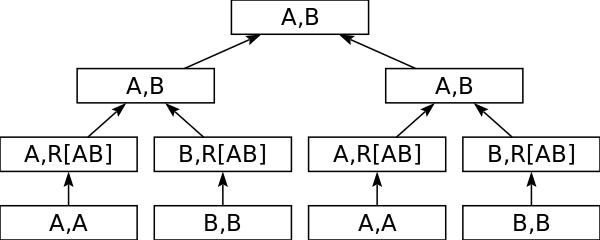

In [2]:
p = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
    
drawPolicy $ (p <||> p) <> Distill ("A", "B")

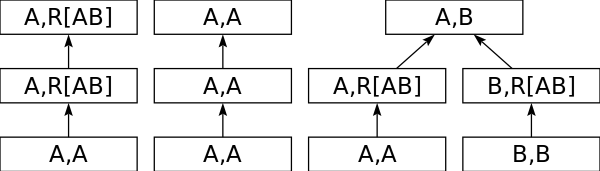

In [3]:
drawPolicy $ (Create "A" <||> Create "A" <||> Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||>Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")

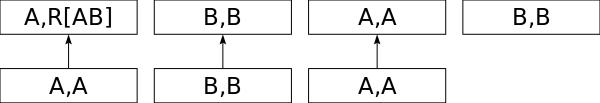

In [4]:
drawPolicy $ 
    (Create "A" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "B" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "A" <> Transmit "B" ("B", "R[AB]"))
    <||> Create "B" 

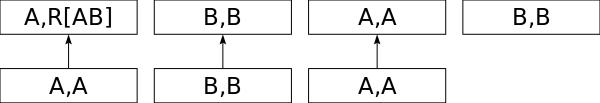

In [5]:
drawPolicy $ 
    Create "A" <> Transmit "A" ("A", "R[AB]")
    <||> Create "B" <> Transmit "A" ("A", "R[AB]") 
    <||> (Create "A" <> Transmit "B" ("B", "R[AB]")) {- where is this A,A? -}
    <||> Create "B" 

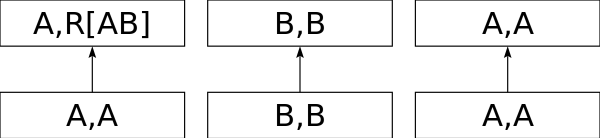

In [6]:
drawPolicy $ 
    Create "A" <> Transmit "A" ("A", "R[AB]")
    <||> Create "B" <> Transmit "A" ("A", "R[AB]") 
    <||> (Create "A" <> Transmit "B" ("B", "R[AB]"))  {- here is A,A as expected, above it vanishes -}
   

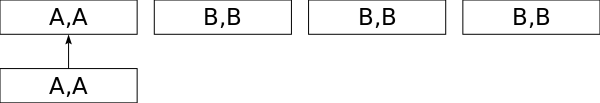

In [7]:
drawPolicy $  Create "A" <> Transmit "B" ("B", "R[AB]") <||> Create "B" <||> Create "B" <||> Create "B" 
{- something to do with the lack of () -}

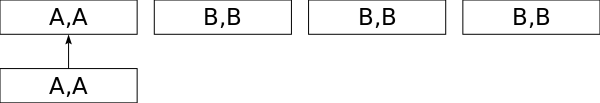

In [8]:
drawPolicy $  (Create "A" <> Transmit "B" ("B", "R[AB]")) <||> Create "B" <||> Create "B" <||> Create "B" 

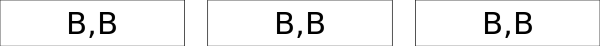

In [20]:
drawPolicy $   Create "B" <||> Create "B" <||> Create "B" <||> Transmit "B" ("B", "R[AB]") 

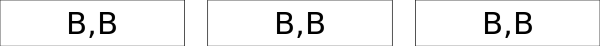

In [ ]:
drawPolicy $ Transmit "B" ("B", "R[AB]") <||> (Create "B" <||> Create "B" <||> Create "B")

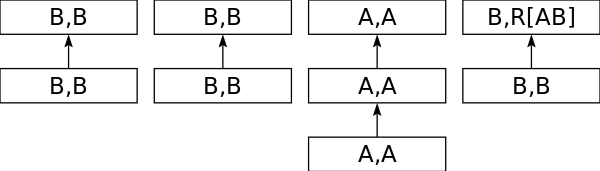

In [9]:
drawPolicy $  ((Create "A" <> Transmit "B" ("B", "R[AB]")) <||> Create "B" <||> Create "B" <||> Create "B" ) <>Transmit "B" ("B", "R[AB]") <||> Transmit "A" ("A", "R[AB]")

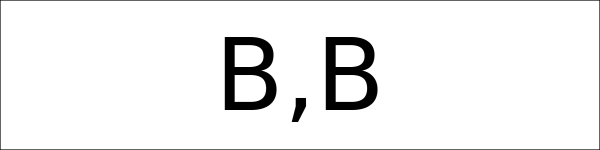

In [34]:
drawPolicy $ (Transmit "B" ("B", "R[AB]") <||> Create "B"  <> Transmit "B" ("B", "R[AB]") ) <||> Create "B"

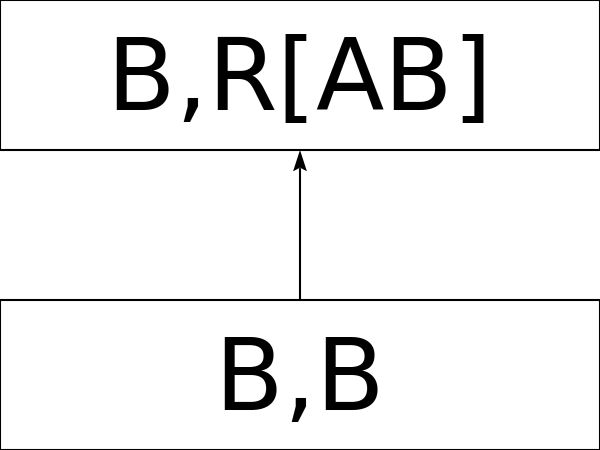

In [36]:
drawPolicy $ Transmit "B" ("B", "R[AB]") <||> Create "B"  <> Transmit "B" ("B", "R[AB]") 

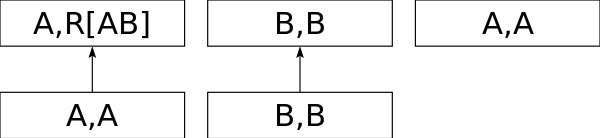

In [10]:
drawPolicy $ 
    Create "A" <> Transmit "A" ("A", "R[AB]")
    <||> Create "B" <> Transmit "A" ("A", "R[AB]") <||> Create "A" 
   

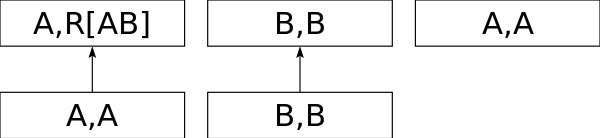

In [11]:
drawPolicy $ 
     Create "A" <> Transmit "A" ("A", "R[AB]")
    <||> ( Create "B" <> Transmit "A" ("A", "R[AB]")  <||> Create "A" )
   

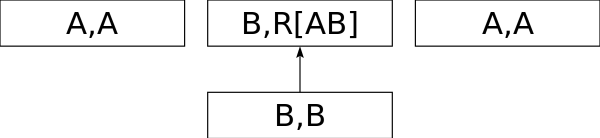

In [12]:
drawPolicy $ 
     Create "A" 
    <||>  ( Create "B" <> Transmit "B" ("B", "R[AB]")  <||> Create "A"  )
   

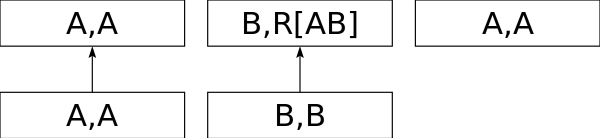

In [44]:
drawPolicy $ 
     Create "A" 
    <||>  Create "B" <> Transmit "B" ("B", "R[AB]")  <||> Create "A" 
   

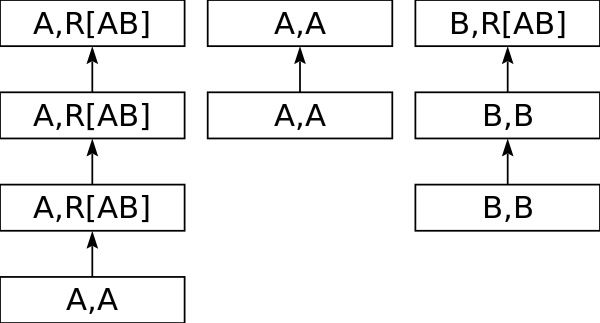

In [29]:
drawPolicy $ 
    Create "A" <> Transmit "A" ("A", "R[AB]")
    <||> Create "B" <> Transmit "A" ("A", "R[AB]") <||> Create "A" <> Transmit "B" ("B", "R[AB]")
   

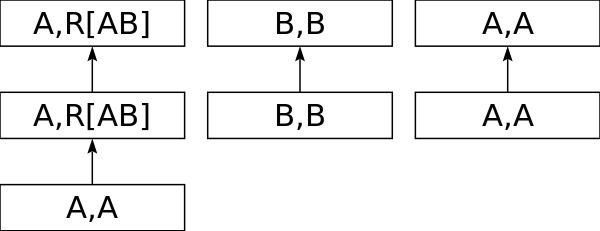

In [31]:
drawPolicy $ 
    Create "A" <> Transmit "A" ("A", "R[AB]")
    <||> Create "B" <> Transmit "A" ("A", "R[AB]") <||> (Create "A" <> Transmit "B" ("B", "R[AB]")) 
    {- why is here create A on the same level as create B? -}
   

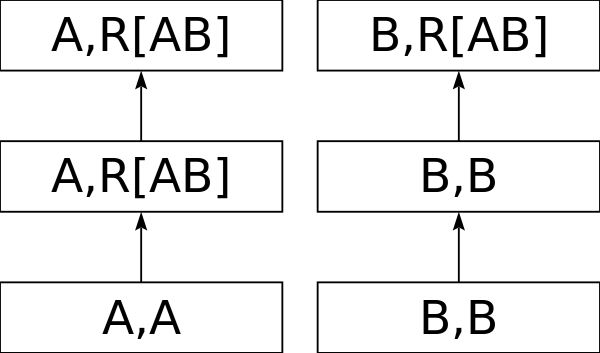

In [5]:
drawPolicy $ 
    (Create "A" <||> Create "B") <> Transmit "A" ("A", "R[AB]") <> Transmit "B" ("B", "R[AB]")

Line 5: Redundant bracket
Found:
(Transmit "B" ("B", "R[AB]") <||> Create "B")
  <> (Swap "R[AB]" ("A", "B"))
Why not:
(Transmit "B" ("B", "R[AB]") <||> Create "B")
  <> Swap "R[AB]" ("A", "B")

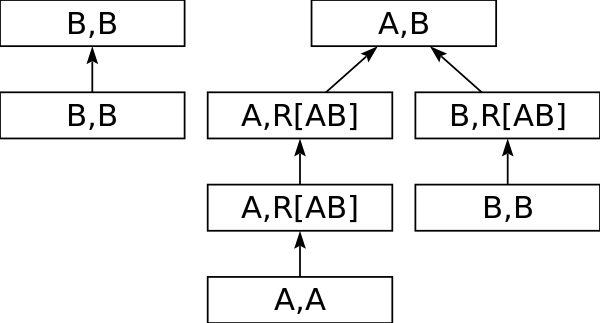

In [6]:
drawPolicy $ 
    Create "A"
    <> (Transmit "A" ("A", "R[AB]") <||> Create "B") 
    <> (Transmit "B" ("B", "R[AB]") {- <||> Identity ("A", "R[AB]") -} <||> Create "B")
    <> (Swap "R[AB]" ("A", "B") {- <||> Identity ("B", "B") -})

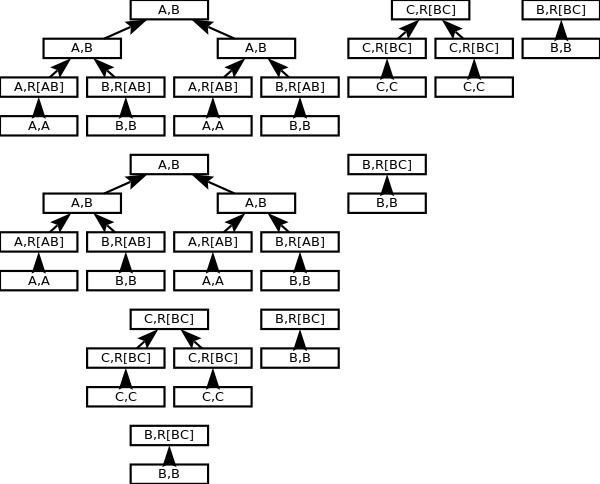

In [7]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")

drawPolicy $ ((pAB <||> pAB) <> Distill ("A", "B")) <||> (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]")) )

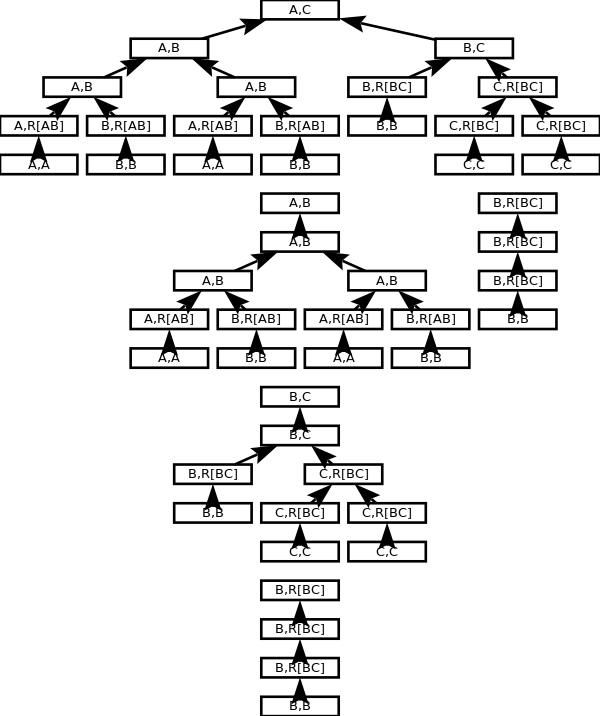

In [8]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")


drawPolicy $ (((pAB <||> pAB) <> Distill ("A", "B")) <||> pBC ) <> Swap "B" ("A", "C")

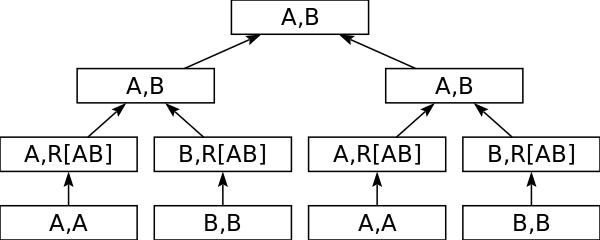

In [9]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")

drawPolicy ((pAB <||> pAB) <> Distill ("A", "B"))

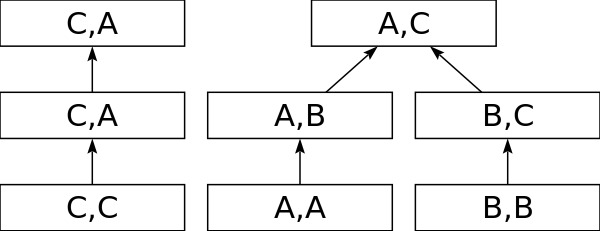

In [10]:
drawPolicy $ (Create "A" <||> Create "B" <||> Create "C") <> (Transmit "A" ("A", "B") <||> Transmit "B" ("B", "C") <||> Transmit "C" ("C", "A")) <> Swap "B" ("A", "C")

## Question

 * Show failures as part of the history? Could be too much of information?
 * Failures in distill and swap?
 * reachability in practice (only with some probability)
 * Simulating the actual run of the policy?
 * Generate the policy from probability